# ImageNet - Bayesian Optimization 
## 02463 Active ML and Agency - Group BO 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

import skopt
from skopt import gp_minimize
import json

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Download the CIFAR-100 dataset (train and test)
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders - BATCH SIZE IS SUBJECTIVE TO CHANGE 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Check the data
images, labels = next(iter(trainloader))

100%|██████████| 169M/169M [01:54<00:00, 1.47MB/s] 


In [5]:
from train_model import train_model

params = {
    'module__base_channels': 16,                    # or try: 32
    'module__dropout': 0.5,                        # or try: 0.3
}
# Train for 10 epochs using 1000 training samples (adjust as needed)
accuracy = train_model(params, num_epochs=10, n_training_samples=1000)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 5.1 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 17.1 K | train
---------

Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 224.89it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 223.50it/s]
Test Accuracy: 3.95%


In [6]:


# Define the search space as follows
# params = {
#     'module__base_channels': (1,128)
#     'module__dropout': (0.0, 0.9)
# }

space = [
    skopt.space.Integer(1, 128, name='module__base_channels'),
    # skopt.space.Real(0.0, 0.9, name='module__dropout')
]

def objective(x):
    # Decode the JSON encoded categorical values.
    params = {
        'module__base_channels': x[0],
        # 'module__dropout': x[1] ,
    }
    
    accuracy = train_model(params, num_epochs=10, n_training_samples=10000)
    # Return negative accuracy for minimization.
    return -accuracy

opt_bo = gp_minimize(
    objective,
    space,
    acq_func='EI',
    n_calls=20,
    n_random_starts=5,
    verbose=True,
    xi=0.1,
    noise=0.01**2
)


Iteration No: 1 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 201 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 261 K  | train
---------------------------------------------------------
462 K     Trainable params
0         Non-trainable params
462 K     Total params
1.852     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 282.92it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 282.68it/s]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.0857
Function value obtained: -0.1894
Current minimum: -0.1894
Iteration No: 2 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 4.5 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 15.8 K | train
---------------------------------------------------------
20.3 K    Trainable params
0         Non-trainable params
20.3 K    Total params
0.081     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 322.76it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 322.42it/s]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.2647
Function value obtained: -0.1194
Current minimum: -0.1894
Iteration No: 3 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 5.7 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 18.5 K | train
---------------------------------------------------------
24.2 K    Trainable params
0         Non-trainable params
24.2 K    Total params
0.097     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 314.42it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 314.14it/s]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.0583
Function value obtained: -0.1126
Current minimum: -0.1894
Iteration No: 4 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 12.0 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 30.3 K | train
---------------------------------------------------------
42.3 K    Trainable params
0         Non-trainable params
42.3 K    Total params
0.169     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 306.45it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 306.19it/s]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.6895
Function value obtained: -0.1329
Current minimum: -0.1894
Iteration No: 5 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 18.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 40.5 K | train
---------------------------------------------------------
58.8 K    Trainable params
0         Non-trainable params
58.8 K    Total params
0.235     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 310.93it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 310.63it/s]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 11.7579
Function value obtained: -0.1306
Current minimum: -0.1894
Iteration No: 6 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 245 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 309 K  | train
---------------------------------------------------------
554 K     Trainable params
0         Non-trainable params
554 K     Total params
2.219     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 285.44it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 285.18it/s]
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 12.7471
Function value obtained: -0.2102
Current minimum: -0.2102
Iteration No: 7 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 298 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 365 K  | train
---------------------------------------------------------
664 K     Trainable params
0         Non-trainable params
664 K     Total params
2.658     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 260.60it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 260.42it/s]
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 13.7055
Function value obtained: -0.1953
Current minimum: -0.2102
Iteration No: 8 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 126 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 177 K  | train
---------------------------------------------------------
303 K     Trainable params
0         Non-trainable params
303 K     Total params
1.216     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 305.88it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 305.59it/s]
Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 11.6943
Function value obtained: -0.1926
Current minimum: -0.2102
Iteration No: 9 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 80.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 123 K  | train
---------------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.814     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 311.23it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 310.99it/s]
Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 11.5123
Function value obtained: -0.1898
Current minimum: -0.2102
Iteration No: 10 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 50.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 85.4 K | train
---------------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.542     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 317.00it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 316.69it/s]
Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 11.3395
Function value obtained: -0.1760
Current minimum: -0.2102
Iteration No: 11 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 48     | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 924    | train
---------------------------------------------------------
972       Trainable params
0         Non-trainable params
972       Total params
0.004     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 323.93it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 323.64it/s]
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 11.0736
Function value obtained: -0.0115
Current minimum: -0.2102
Iteration No: 12 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 161 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 217 K  | train
---------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.517     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 310.03it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 309.74it/s]
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 11.5348
Function value obtained: -0.1966
Current minimum: -0.2102
Iteration No: 13 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 100 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 147 K  | train
---------------------------------------------------------
248 K     Trainable params
0         Non-trainable params
248 K     Total params
0.993     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 312.03it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 311.71it/s]
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 11.4462
Function value obtained: -0.1920
Current minimum: -0.2102
Iteration No: 14 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 34.6 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 64.4 K | train
---------------------------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 316.13it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 315.81it/s]
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 11.6748
Function value obtained: -0.1573
Current minimum: -0.2102
Iteration No: 15 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 271 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 336 K  | train
---------------------------------------------------------
608 K     Trainable params
0         Non-trainable params
608 K     Total params
2.434     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 272.17it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 271.93it/s]
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 13.1152
Function value obtained: -0.2226
Current minimum: -0.2226
Iteration No: 16 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 64.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 103 K  | train
---------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.672     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 314.92it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 314.64it/s]
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 11.4551
Function value obtained: -0.1550
Current minimum: -0.2226
Iteration No: 17 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 145 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 198 K  | train
---------------------------------------------------------
343 K     Trainable params
0         Non-trainable params
343 K     Total params
1.376     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 309.25it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 308.99it/s]
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 11.6616
Function value obtained: -0.1893
Current minimum: -0.2226
Iteration No: 18 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 221 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 282 K  | train
---------------------------------------------------------
503 K     Trainable params
0         Non-trainable params
503 K     Total params
2.015     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 296.34it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 296.13it/s]
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 12.1537
Function value obtained: -0.2011
Current minimum: -0.2226
Iteration No: 19 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 179 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 236 K  | train
---------------------------------------------------------
416 K     Trainable params
0         Non-trainable params
416 K     Total params
1.665     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 291.76it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 291.53it/s]
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 12.1788
Function value obtained: -0.1963
Current minimum: -0.2226
Iteration No: 20 started. Searching for the next optimal point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 25.8 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 51.9 K | train
---------------------------------------------------------
77.7 K    Trainable params
0         Non-trainable params
77.7 K    Total params
0.311     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 314.64it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 314.36it/s]
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 11.5700
Function value obtained: -0.1509
Current minimum: -0.2226


In [16]:
# do random search
from skopt import dummy_minimize
opt_random = dummy_minimize(
    objective,
    space,
    n_calls=20,
    verbose=True,
    random_state=42
)


Iteration No: 1 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 190 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 248 K  | train
---------------------------------------------------------
439 K     Trainable params
0         Non-trainable params
439 K     Total params
1.757     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 295.34it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 295.05it/s]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.3163
Function value obtained: -0.2054
Current minimum: -0.2054
Iteration No: 2 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 11.1 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 28.7 K | train
---------------------------------------------------------
39.8 K    Trainable params
0         Non-trainable params
39.8 K    Total params
0.159     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 318.47it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 318.18it/s]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.3580
Function value obtained: -0.1284
Current minimum: -0.2054
Iteration No: 3 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 183 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 240 K  | train
---------------------------------------------------------
423 K     Trainable params
0         Non-trainable params
423 K     Total params
1.696     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 307.26it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 306.98it/s]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.9080
Function value obtained: -0.1799
Current minimum: -0.2054
Iteration No: 4 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 109 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 157 K  | train
---------------------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.065     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 309.76it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 309.51it/s]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.5623
Function value obtained: -0.1842
Current minimum: -0.2054
Iteration No: 5 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 62.3 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 100 K  | train
---------------------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.652     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 311.77it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 311.53it/s]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 11.3787
Function value obtained: -0.1818
Current minimum: -0.2054
Iteration No: 6 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 3.9 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 14.5 K | train
---------------------------------------------------------
18.5 K    Trainable params
0         Non-trainable params
18.5 K    Total params
0.074     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 322.23it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 321.92it/s]
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 11.0961
Function value obtained: -0.1027
Current minimum: -0.2054
Iteration No: 7 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 64.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 103 K  | train
---------------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.672     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 311.68it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 311.42it/s]
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 11.7890
Function value obtained: -0.1731
Current minimum: -0.2054
Iteration No: 8 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 34.6 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 64.4 K | train
---------------------------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 312.29it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 311.99it/s]
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 11.4160
Function value obtained: -0.1574
Current minimum: -0.2054
Iteration No: 9 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 7.1 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 21.2 K | train
---------------------------------------------------------
28.3 K    Trainable params
0         Non-trainable params
28.3 K    Total params
0.113     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 323.90it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 323.59it/s]
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 11.1552
Function value obtained: -0.1252
Current minimum: -0.2054
Iteration No: 10 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 129 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 180 K  | train
---------------------------------------------------------
310 K     Trainable params
0         Non-trainable params
310 K     Total params
1.242     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 311.86it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 311.58it/s]
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 11.4467
Function value obtained: -0.1820
Current minimum: -0.2054
Iteration No: 11 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 1.4 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 7.6 K  | train
---------------------------------------------------------
9.0 K     Trainable params
0         Non-trainable params
9.0 K     Total params
0.036     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 319.87it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 319.55it/s]
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 11.3406
Function value obtained: -0.0913
Current minimum: -0.2054
Iteration No: 12 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 158 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 213 K  | train
---------------------------------------------------------
372 K     Trainable params
0         Non-trainable params
372 K     Total params
1.488     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 315.82it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 315.53it/s]
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 11.6193
Function value obtained: -0.1796
Current minimum: -0.2054
Iteration No: 13 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 262 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 327 K  | train
---------------------------------------------------------
590 K     Trainable params
0         Non-trainable params
590 K     Total params
2.361     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 279.08it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 278.80it/s]
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 12.9668
Function value obtained: -0.2124
Current minimum: -0.2124
Iteration No: 14 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 48     | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 924    | train
---------------------------------------------------------
972       Trainable params
0         Non-trainable params
972       Total params
0.004     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 327.61it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 327.28it/s]
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 10.9414
Function value obtained: -0.0193
Current minimum: -0.2124
Iteration No: 15 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 294 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 360 K  | train
---------------------------------------------------------
654 K     Trainable params
0         Non-trainable params
654 K     Total params
2.620     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 255.99it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 255.76it/s]
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 14.1527
Function value obtained: -0.2069
Current minimum: -0.2124
Iteration No: 16 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 114 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 163 K  | train
---------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.114     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 310.44it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 310.11it/s]
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 11.5129
Function value obtained: -0.1915
Current minimum: -0.2124
Iteration No: 17 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 114 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 163 K  | train
---------------------------------------------------------
278 K     Trainable params
0         Non-trainable params
278 K     Total params
1.114     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 304.49it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 304.24it/s]
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 11.7147
Function value obtained: -0.1679
Current minimum: -0.2124
Iteration No: 18 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 132    | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 1.8 K  | train
---------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 322.28it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 321.96it/s]
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 11.2026
Function value obtained: -0.0416
Current minimum: -0.2124
Iteration No: 19 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 408    | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 3.6 K  | train
---------------------------------------------------------
4.0 K     Trainable params
0         Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 315.84it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:00<00:00, 315.50it/s]
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 11.4527
Function value obtained: -0.0514
Current minimum: -0.2124
Iteration No: 20 started. Evaluating function at random point.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 85.3 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 129 K  | train
---------------------------------------------------------
214 K     Trainable params
0         Non-trainable params
214 K     Total params
0.857     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 309.81it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:01<00:00, 309.56it/s]
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 11.8218
Function value obtained: -0.1764
Current minimum: -0.2124


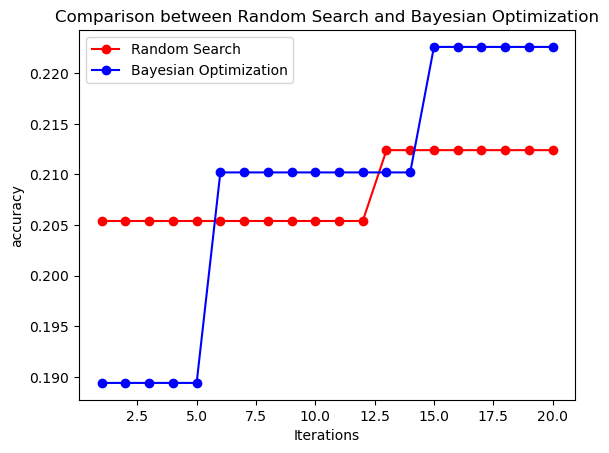

In [17]:
## comparison between random search and bayesian optimization
## we can plot the maximum oob per iteration of the sequence

# collect the maximum each iteration of BO
y_bo = np.maximum.accumulate(-opt_bo.func_vals).ravel()
y_random = np.maximum.accumulate(-opt_random.func_vals).ravel()
# define iteration number
xs = range(1, len(y_bo) + 1)

plt.plot(xs, y_random, 'o-', color = 'red', label='Random Search')
plt.plot(xs, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('accuracy')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.show()

In [20]:
# get the max pariter

opt_bo.x_iters[np.argmax(-opt_bo.func_vals)]

print(opt_random)
print(opt_bo)

          fun: -0.2124
            x: [np.int64(120)]
    func_vals: [-2.054e-01 -1.284e-01 ... -5.140e-02 -1.764e-01]
      x_iters: [[np.int64(102)], [np.int64(24)], [np.int64(100)], [np.int64(77)], [np.int64(58)], [np.int64(14)], [np.int64(59)], [np.int64(43)], [np.int64(19)], [np.int64(84)], [np.int64(8)], [np.int64(93)], [np.int64(120)], [np.int64(1)], [np.int64(127)], [np.int64(79)], [np.int64(79)], [np.int64(2)], [np.int64(4)], [np.int64(68)]]
       models: []
        space: Space([Integer(low=1, high=128, prior='uniform', transform='normalize')])
 random_state: RandomState(MT19937)
        specs:     args:                    func: <function objective at 0x7f5412788540>
                                      dimensions: [Integer(low=1, high=128, prior='uniform', transform='normalize')]
                                  base_estimator: dummy
                                         n_calls: 20
                                 n_random_starts: None
                                